
Load datasets stored in .tfrecord file format
=======================================

This example demonstrates how to load the data from a stored .tfrecord file and to build a 
data generator.

At first, a small temporary dataset compounding 5 source cases is created by utilizing Dataset1. The conventional beamforming map is included by specifying `sourcemap` as the desired feature.    

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from acoupipe.datasets.dataset1 import Dataset1
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # change tensorflow log level for doc purposes

# training dataset
d1 = Dataset1(
        f=1000,
        features=["sourcemap"])

# save to .h5 file
d1.save_tfrecord(split="training", size=5, name="/tmp/dataset.tfrecord")

2023-02-02 12:25:45.009591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 12:25:45.123282: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-02 12:25:45.125983: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-02 12:25:45.125994: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

To parse the data from TFRecord files it is necessary to write a custom function that parses the file sequentially
(see: TFRecord_ documentation for details).

A potential parser function for the :code:`'sourcemap'` feature can be similar to:


In [2]:

def tfrecord_parser(record):
    """ parser for tfrecord datasets with 'csmtriu' feature """
    parsed = tf.io.parse_single_example(
        record, 
        {
        'sourcemap': tf.io.VarLenFeature(tf.float32),
        'p2': tf.io.VarLenFeature(tf.float32),
        'loc' : tf.io.VarLenFeature(tf.float32),
        }
    )
    sourcemap = tf.reshape(tf.sparse.to_dense(parsed['sourcemap']),shape=(64,64))
    p2 = tf.sparse.to_dense(parsed['p2'])
    loc = tf.reshape(tf.sparse.to_dense(parsed['loc']),[3,-1])  
    return (sourcemap, p2, loc)

Now one can load the Dataset with the TensorFlow Dataset API

2023-02-02 12:25:55.868036: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-02 12:25:55.868056: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-02 12:25:55.868070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (adku): /proc/driver/nvidia/version does not exist
2023-02-02 12:25:55.868319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


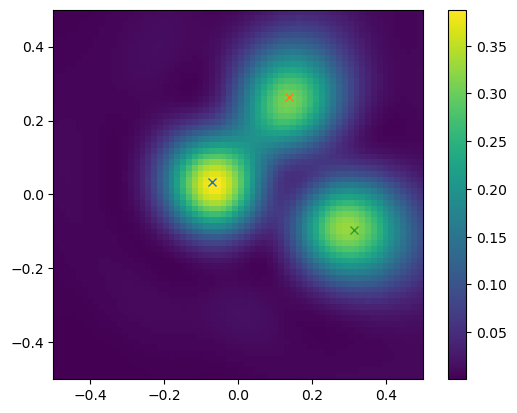

In [3]:

dataset = tf.data.TFRecordDataset(
    filenames=["/tmp/dataset.tfrecord"],
).map(tfrecord_parser)

dataset_iter = iter(dataset)
sourcemap, p2, loc = next(dataset_iter)

plt.figure()
plt.imshow(sourcemap.numpy().T,extent=(-.5,.5,-.5,.5),origin='lower')
for l in loc[:2].numpy().T:
    plt.plot(l[0],l[1],'x')
plt.colorbar()
plt.show()